In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy 
import json
import networkx as nx
import pulp

from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

In [2]:
# Pulser imports
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice,DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig



In [3]:
from pulser.channels import DMM
from pulser.register.register_layout import RegisterLayout
from pulser.register.mappable_reg import MappableRegister
from pulser.register.weight_maps import DetuningMap

Text(0.5, 1.0, 'Population of North Carl, N=1000')

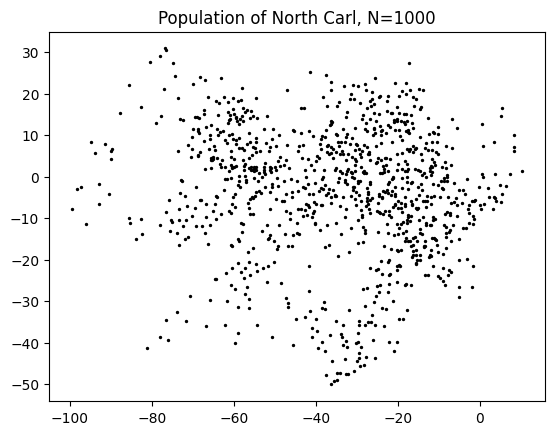

In [342]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[5]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [343]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))]) # x-y coordinates of houses
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]]) # position of the ith antenna
        for j in range(len(placement)):
            coord_j = np.array([placement[j]]) # position of the jth antenna
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist: # checking whether distance between ith and jth < 2R
                    cost += -B # penalising the cost function.


        dist = scipy.spatial.distance.cdist(coord_i, coords) # checking the distance between ith antenna and all houses.
        cov = np.sum(dist < R_dist) # checking whether the distance < R
        cost += cov # maximising cost function

    if cost < 0:
        return -np.inf
    else:
        return cost
    
R_antennas = 25

K-Means Lattice Generation

In [344]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_
antenna_pos = centers.copy()

Text(0.5, 1.0, 'Population of North Carl, N=1000')

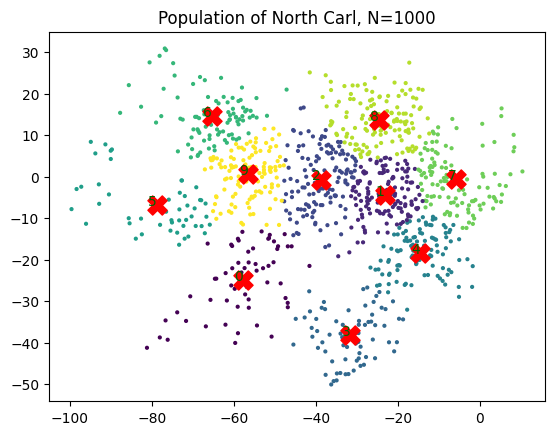

In [345]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))


Graph Generation

In [346]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

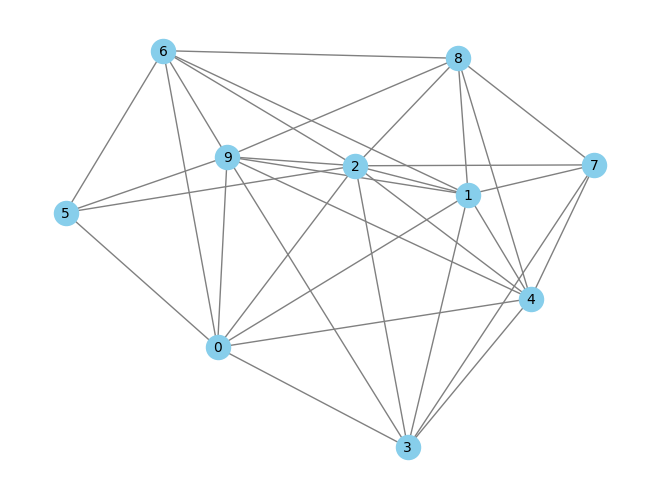

In [347]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

UDG embedding

In [356]:
coords = antenna_pos.copy()
val = np.min(pdist(coords))
coords *= 5/val

In [357]:
device_used = MockDevice
seed = 100

In [362]:
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
r = 2*R_antennas*5/val
omega_rb = device_used.interaction_coeff/r**6


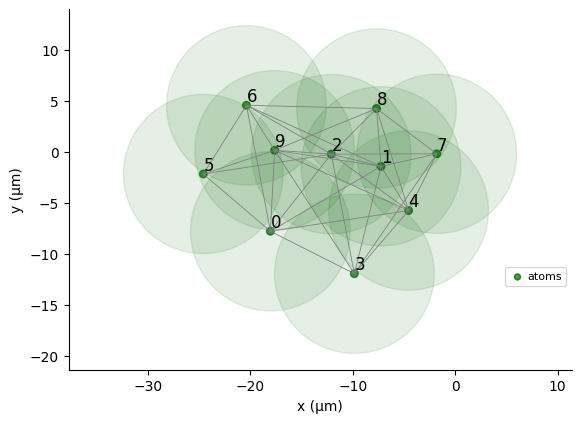

In [363]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
R =  np.median(Q[Q>0].flatten())
reg.draw(
    blockade_radius = device_used.rydberg_blockade_radius(omega_rb),
    draw_graph = True,
    draw_half_radius = True, 
)

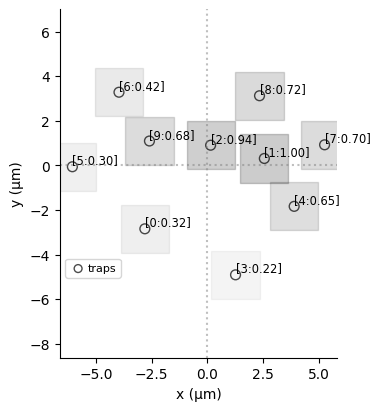

In [374]:
qubits = dict(enumerate(coords))
reg = Register.from_coordinates(coords)
qubit_ids = list(qubits.keys())
#qubit_ids

w = z_coverage/max(z_coverage)
#print(w)
#w = w/sum(w)
detuning_map = reg.define_detuning_map({qubit_ids[i]: w[i] for i in range(len(w))})
detuning_map.draw(labels=qubit_ids)

In [366]:
# Set time values
t_rise = 500 # we need to set these values
t_sweep = 1500
t_fall = 500

omega_max = omega_rb#np.median(Q[Q>0].flatten())
delta_0 = -3*omega_max
delta_f = 3*omega_max

In [367]:
# # Set the pulse
# rise = Pulse.ConstantDetuning(
#     amplitude=RampWaveform(duration=t_rise, start=0.0, stop=omega_max), detuning=delta_0, phase=0.0
# )

# sweep = Pulse.ConstantAmplitude(
#     amplitude=omega_max, detuning=RampWaveform(duration=t_sweep,start=delta_0,stop=delta_f), phase=0.0
# )

# fall = Pulse.ConstantDetuning(
#     amplitude=RampWaveform(duration=t_fall, start=omega_max, stop=0.0), detuning=delta_f, phase=0.0
# )




In [368]:
# seq = Sequence(reg, device_used)
# seq.config_detuning_map(detuning_map, "dmm_0")
# seq.declare_channel("ising", "rydberg_global")


# seq.add_dmm_detuning(ConstantWaveform(duration=t_rise+t_sweep,value=3*delta_0), "dmm_0")
# seq.add_dmm_detuning(RampWaveform(duration=t_fall,start=3*delta_0,stop=0), "dmm_0")
# # seq.add_dmm_detuning(ConstantWaveform(duration=t_fall,value=delta_0), "dmm_0")
# seq.add(rise, "ising", "no-delay")
# seq.add(sweep, "ising", "no-delay")
# seq.add(fall, "ising", "no-delay")
# # seq.measure(basis="ground-rydberg")


In [369]:
coords = antenna_pos.copy()
val = np.min(pdist(coords))
coords *= 5/val

device_used = MockDevice
seed = 100

In [370]:
# Set time values
# t_rise = 200 # we need to set these values
# t_sweep = 1400
# t_fall = 200


omega_max = 2*np.pi*4#np.median(Q[Q>0].flatten())
# delta_0 = -3*omega_max
# delta_f = 3*omega_max
delta_0 = -6 * omega_max
delta_f = 2 * omega_max
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 2000


t_total = t_rise+t_sweep+t_fall
t_rise_norm = t_rise/ t_total
t_sweep_norm = t_sweep / t_total
t_fall_norm = t_fall / t_total

In [ ]:
# rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
# factor = 5/val
# R_antennas = 25*factor
# factor_for_rydberg_scaling = rydberg_radius/(2*R_antennas)
# R_antennas = R_antennas * factor_for_rydberg_scaling
# coords = coords * factor_for_rydberg_scaling

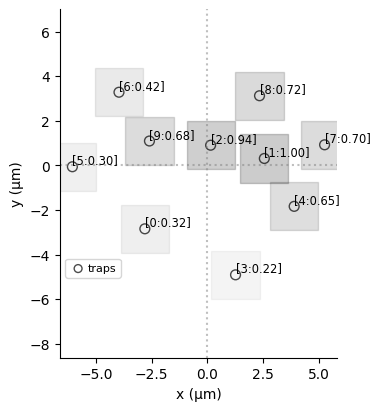

In [ ]:
qubits = dict(enumerate(coords))
reg = Register.from_coordinates(coords)
qubit_ids = list(qubits.keys())
w = z_coverage/max(z_coverage)
detuning_map = reg.define_detuning_map({qubit_ids[i]: w[i] for i in range(len(w))})
detuning_map.draw(labels=qubit_ids)

In [324]:
detuning_wf = RampWaveform(duration=t_total, start=delta_0, stop=delta_f)

amplitued_wf = InterpolatedWaveform(t_total,
                [0, omega_max, omega_max, 0],
                [0, t_rise_norm, t_rise_norm + t_sweep_norm, 1])

rabi_pulse = Pulse(amplitude=amplitued_wf,detuning=detuning_wf,phase=0.0)

In [325]:
seq = Sequence(reg, device_used)
seq.config_detuning_map(detuning_map, "dmm_0")
seq.declare_channel("ising", "rydberg_global")


seq.add_dmm_detuning(ConstantWaveform(duration=t_total,value=delta_0), "dmm_0")
# seq.add_dmm_detuning(RampWaveform(duration=t_fall,start=5*delta_0,stop=0), "dmm_0")
seq.add(rabi_pulse, "ising", "no-delay")

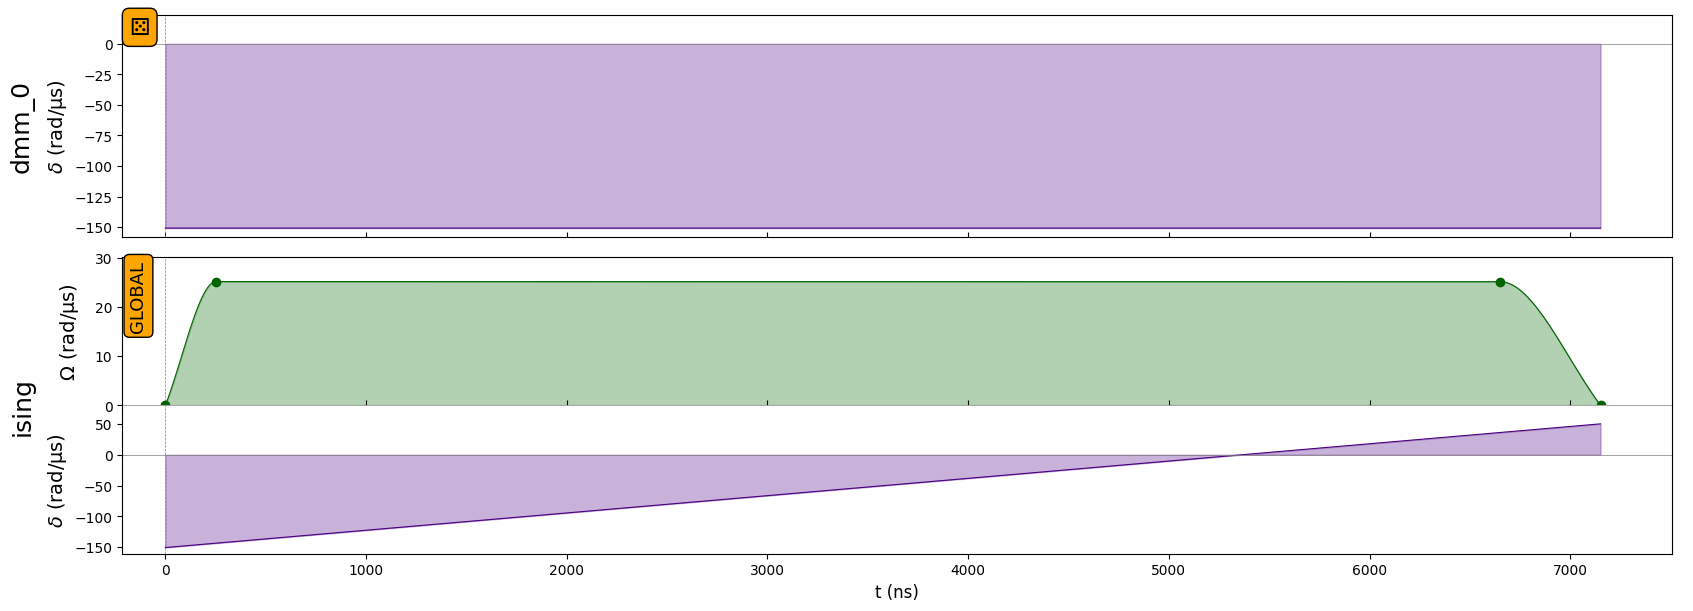

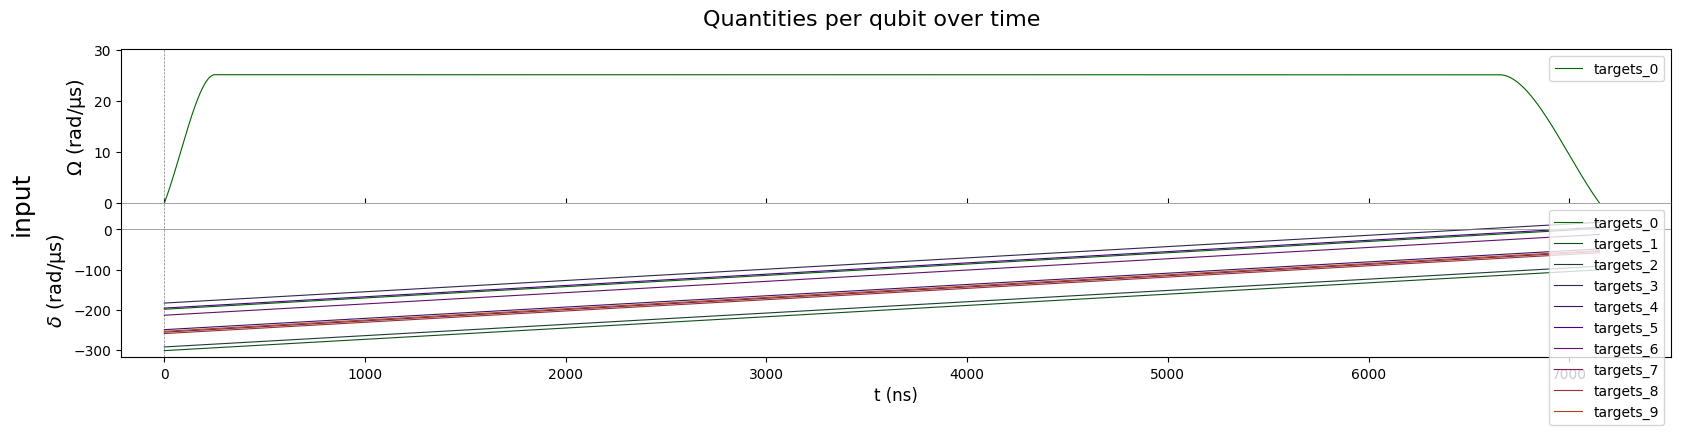

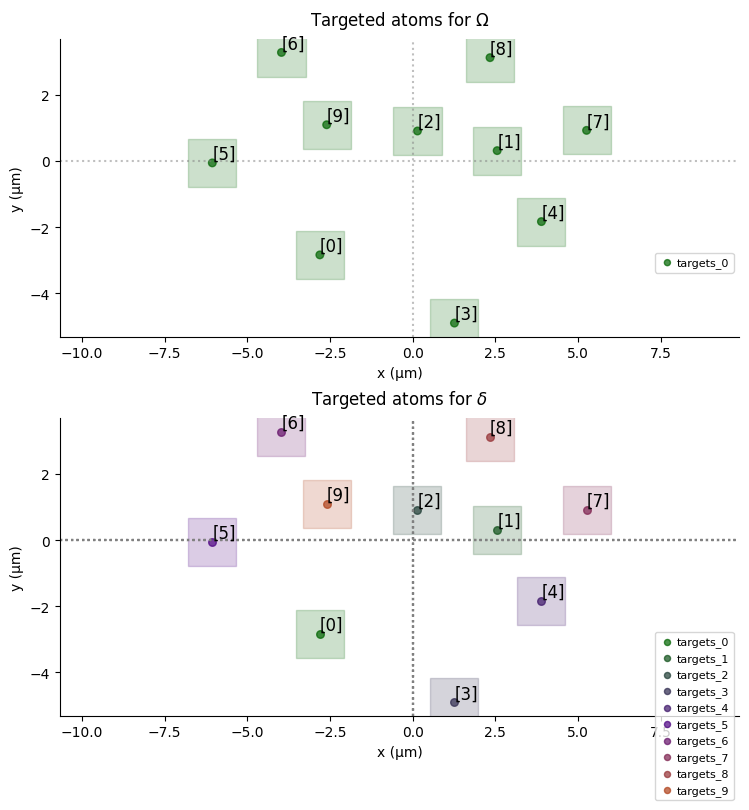

In [326]:
seq.draw(
    mode="input+output",  # "input" only shows input signals, "input+output"
    draw_qubit_det=True,
    draw_qubit_amp=True,
)

In [335]:
# Set noise configurations
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}

In [328]:
# Set simulator
simulator = QutipEmulator.from_sequence(
    sequence = seq,
    sampling_rate = 0.01,
    with_modulation = False,
    config = noise_config["noiseless"],
)

simulator.show_config()
results = simulator.run(progress_bar = True)
count_dict = results.sample_final_state(N_samples = 1000)

Options:
----------
Number of runs:        15
Samples per run:       5
11.3%. Run time:  85.88s. Est. time left: 00:00:11:16
21.1%. Run time: 168.50s. Est. time left: 00:00:10:29
31.0%. Run time: 253.41s. Est. time left: 00:00:09:24
40.8%. Run time: 314.00s. Est. time left: 00:00:07:34
50.7%. Run time: 390.62s. Est. time left: 00:00:06:19
60.6%. Run time: 460.28s. Est. time left: 00:00:04:59
70.4%. Run time: 527.27s. Est. time left: 00:00:03:41
80.3%. Run time: 591.06s. Est. time left: 00:00:02:25
90.1%. Run time: 659.62s. Est. time left: 00:00:01:12
Total run time: 707.83s


In [336]:
print(count_dict)

Counter({'0001000000': 800, '0001010000': 93, '0000000000': 48, '0000010000': 46, '1000000000': 12, '0001001000': 1})


In [337]:
state = max(count_dict, key=count_dict.get)
posindx= np.where(np.array(list(state)) =='1')
optimal_pos = antenna_pos[posindx]
evaluate_coverage(data,optimal_pos,R_antennas)

11

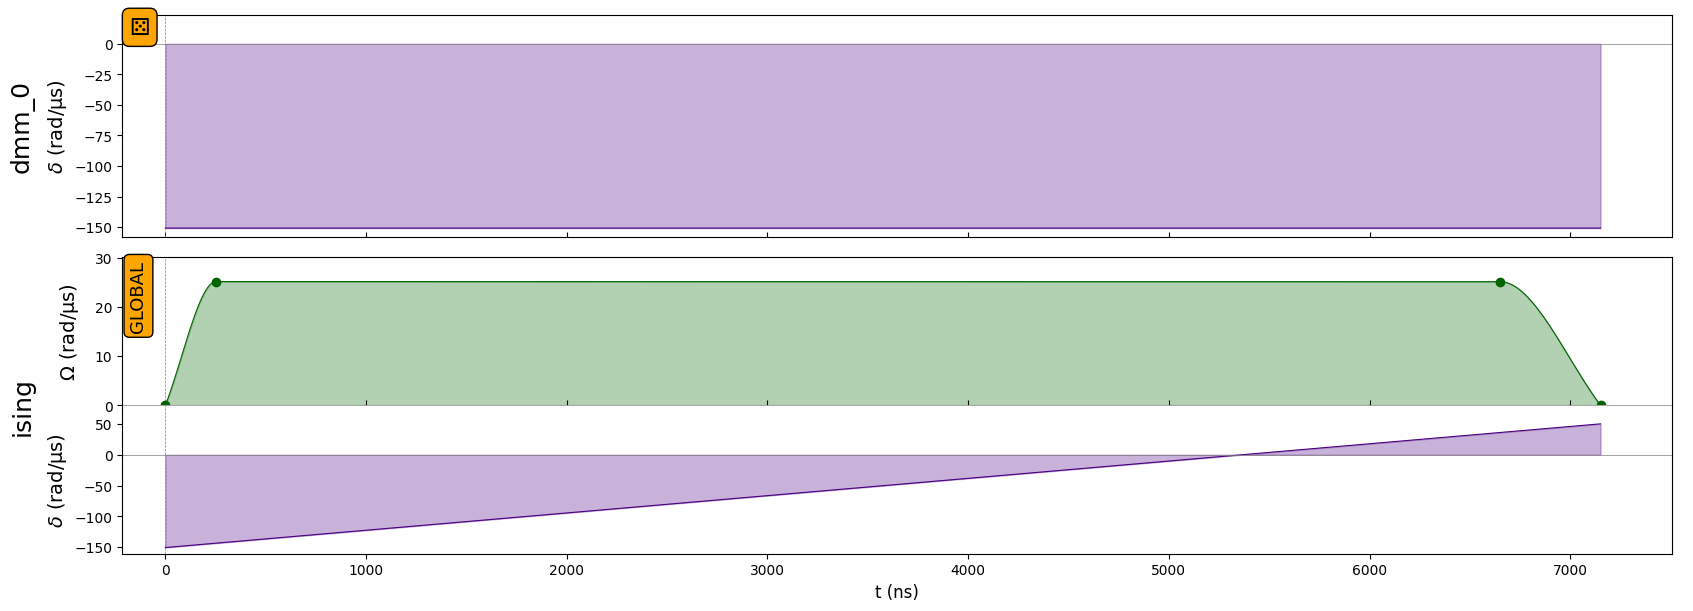

In [375]:
seq.draw()